In [66]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=


In [67]:
import sys

sys.path.append("../")

In [68]:
import fof.dataloader
import transformers as tr
from pathlib import Path
import torchvision
import torch

In [69]:
loader = fof.dataloader.ScicapDataModule(
  "First-Sentence",
  tokenizer=tr.AutoTokenizer.from_pretrained("distilbert-base-uncased"),
  root=Path("../scicap_data"),
  batch_size=10,
  caption_type="normalized",
  num_workers=0, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
  ]))
test = loader.test_dataloader()

Initializing SCICAP training dataset
Initializing SCICAP testing dataset
Initializing SCICAP validation dataset
Time taken: 0.05786609649658203


In [70]:
batch = next(iter(test))
len(batch["figure"])

10

In [71]:
from fof.encdec import EncoderDecoderModel
from fof.dataloader import ScicapDataModule
from pathlib import Path
import wandb
run = wandb.init(project="figuring-out-figures")


In [72]:
def load_model(artifact_str: str = None, ckpt_path: str = None, **kwargs):
    if artifact_str is not None:
        artifact = run.use_artifact(artifact_str, type="model")
        artifact_dir = artifact.download()
        ckpt_path = Path(artifact_dir) / "model.ckpt"
    model = EncoderDecoderModel.load_from_checkpoint(ckpt_path, **kwargs)
    return model


# CLIP + SCIBERT --> DistilGPT2 on original captions
# model = load_model(
#     "figuring-out-figures/figuring-out-figures/model-27py12gz:v1")

# CLIP + SCIBERT --> DistilGPT2 on normalized captions
model = load_model('figuring-out-figures/figuring-out-figures/model-1d7mntmw:v2', use_top_p_sampling=True)

# SCIBERT + GPT2 on original captions
# model = load_model(ckpt_path='/data/kevin/arxiv/evaluation_checkpoints/text-features-only.ckpt')


wandb: Downloading large artifact model-1d7mntmw:v2, 2532.30MB. 1 files... Done. 0:0:0
Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.7.mlp.fc2.weight', 'text_model.encoder.layers.2.layer_norm1.weight', 'text_model.encoder.layers.2.self_attn.out_proj.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.7.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.10.self_attn.q_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.2.s

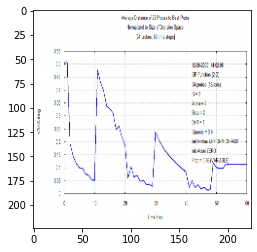

Figure #1
Figure ID: 1001.0317v2-Figure7-1.png
Gold Caption: evolution of gp function avgd.
Model's Caption: evolution of fitness of gp function BRACKET-TK from initial distances calculated by the



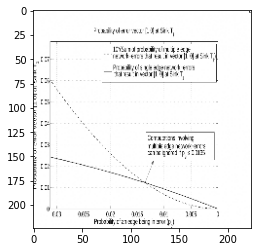

Figure #2
Figure ID: 1001.1026v1-Figure2-1.png
Gold Caption: thresholdpe for the butterfly network at sinkt1.
Model's Caption: comparison of cpc-error probabilities between single edge network EQUAT-TK and



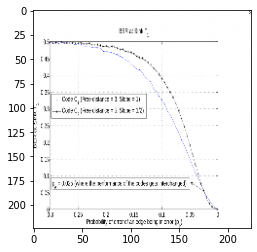

Figure #3
Figure ID: 1001.1026v1-Figure5-1.png
Gold Caption: ber and bounds on ber at sinkt1 for NUM codes.
Model's Caption: the error probability of ncicec/n0 for different values ofpe andrelax



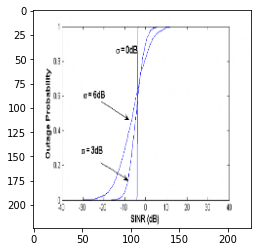

Figure #4
Figure ID: 1001.1110v1-Figure6-1.png
Gold Caption: outage probability for a mobile located at r = rc ; shadowing impact BRACKET-TK for EQUAT-TK.
Model's Caption: outage probability in a cellular network with respect to the distance of the cell when the snr



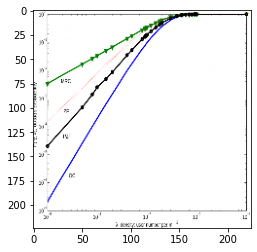

Figure #5
Figure ID: 1001.1482v3-Figure2-1.png
Gold Caption: outage probability : maximal ratio combining, NUM forcing, partial zero forcing BRACKET-TKBRACKET-TK and optimum combining withl=3 EQUAT-TK.
Model's Caption: ber performance comparison of a binary equaliser with NUM antenna elements and 16-ppm rayleigh



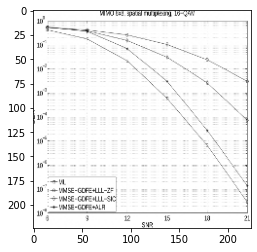

Figure #6
Figure ID: 1001.1625v1-Figure3-1.png
Gold Caption: performance comparison of augmented lattice reduction with lll-zf and lll-sic detection with mmse-gdfe preprocessing for a8× NUM uncoded mimo system using16-qam.
Model's Caption: mse performance versus snr under ml decoding.



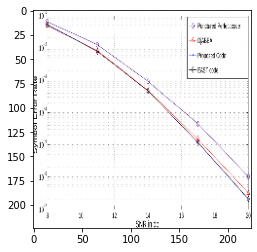

Figure #7
Figure ID: 1001.1872v1-Figure2-1.png
Gold Caption: ser performance at NUM bpcu for codes for4× systems.
Model's Caption: ser versus snr at the ap for NUM NUM, NUM, and NUM NUM mimo.



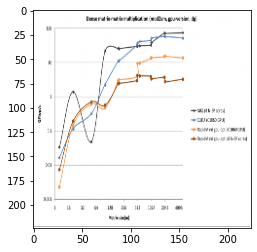

Figure #8
Figure ID: 1001.1902v2-Figure3-1.png
Gold Caption: performance comparision of the gpu-optimized version on various backends. performance measurements have been performed both on an nvidia gpu and a nehalem-ep socket with NUM cores. the rapidmind version is compared to a cuda version based on cublas and an mkl implementation of the dense matrix-matrix multiplication. performance measurements are based on double-precision arithmetic.
Model's Caption: comparison of various variants of the gpu, cpu, and gpu performance on g



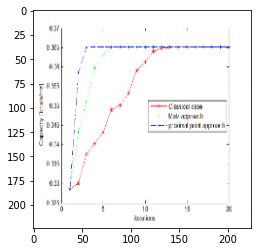

Figure #9
Figure ID: 1001.1915v1-Figure2-1.png
Gold Caption: comparision between the NUM approaches in the case of a dbsc channel.
Model's Caption: lower bound on the rate : p BRACKET-TK = NUM − x/2



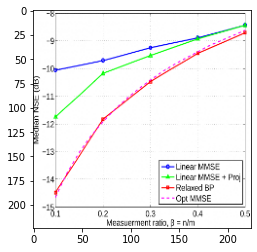

Figure #10
Figure ID: 1001.2228v2-Figure7-1.png
Gold Caption: relaxed bp algorithm with a gaussian prior and bounded noise output channel. the plot compares the simulated relaxed bp performance against the predicted performance based on density evolution. also shown is the performance of the linear mmse estimator with and without projection to the consistent set.
Model's Caption: median squared error over NUM trials for relaxed bp vs EQUAT-TK EQUAT



<Figure size 432x288 with 0 Axes>

In [74]:
torch.manual_seed(42)
decoded, labels = model.run_sampling_batch(*model.process_batch(batch))
assert len(decoded) == len(labels) == 10

import matplotlib.pyplot as plt

for fig_index in range(len(decoded)):
    plt.imshow(batch["figure"][fig_index].permute(
        1, 2, 0).to(torch.uint8) / 255)
    plt.show()
    plt.figure()
    print(f'Figure #{fig_index + 1}')
    print(f"Figure ID: {batch['id'][fig_index]}")
    print(f'Gold Caption: {labels[fig_index]}')
    print(f"Model's Caption: {decoded[fig_index]}\n")

In [ ]:
# for key in ["references", "labels", "title", "id", "abstract"]:
#     print(key, batch[key][0])
# import matplotlib.pyplot as plt
# for fig_index in range(10):
#     plt.imshow(batch["figure"][fig_index].permute(1, 2, 0).to(torch.uint8) / 255)
#     plt.show()
#     print(batch['labels'][fig_index])
#     plt.figure()

